In [1]:
from sklearn.datasets import fetch_openml

In [2]:
mnist=fetch_openml('mnist_784',version=1)

In [3]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

In [4]:
X,y=mnist["data"],mnist["target"]

In [5]:
X.shape

(70000, 784)

In [6]:
y.shape

(70000,)

In [7]:
import matplotlib as mpl
import matplotlib.pyplot as plt

<function matplotlib.pyplot.show(*args, **kw)>

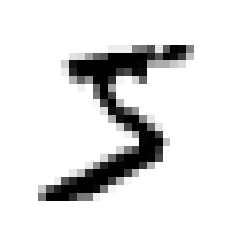

In [8]:
# 샘플의 특성 벡터를 추출해서 28x28로 크기 바꾸기

some_digit=X[0]
some_digit_image=some_digit.reshape(28,28)

plt.imshow(some_digit_image,cmap="binary")
plt.axis('off') #축 없애기
plt.show

In [9]:
# 실제 레이블 확인

y[0]

'5'

In [10]:
import numpy as np
y=y.astype(np.uint8)

In [11]:
# 데이터 조사하기 전에 항상 테스트 세트를 만들고 따로 뗴어놓아야 한다. 

X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# 1. 이진분류기 훈련

In [12]:
# 5와 5 아님으로 두 개의 클래스를 구분할 수 있는 이진분류기
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

## - 경사하강법 

가중치를 조절하는 방법. 정확하게 가중치를 찾아가지만 가중치를 변경할 때마다 전체 데이터에 대해 미분해야 하므로 계산량이 매우 많다. 즉 많은 계산량 때문에 속도가 느리고, 추가적으로 최적해를 찾기 전 학습을 멈출 수도 있다. 이러한 점을 보안한 다양한 경사 하강법이 등장했다. 

### - 확률적 경사 하강법(Stochastic Gradient Descent: SGD)

경사 하강법과 다르게 한번 학습할 때 모든 데이터에 대해 가중치를 조절하는 것이 아니라, 랜덤하게 추출한 일부 데이터에 대해 가중치를 조절한다. 결과적으로 속도는 개선되었지만 최적해의 정확도는 낮다. 따라서 한 번에 하나씩 훈련 샘플을 독립적으로 처리하기 때문에 매우 큰 데이터 셋을 처리하는데 효율적이다. 

훈련을 하는데 무작위성을 사용하여 확률적이란 단어가 붙었다. 결과를 재현하려면 random_state 매개변수를 지정해야 한다. 

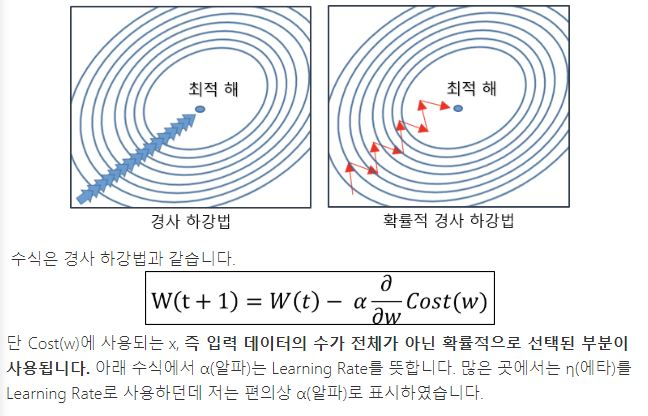


In [13]:
# SGDClassifier 모델을 만들고, 전체 훈련 세트를 사용해 훈련시킨다.

from sklearn.linear_model import SGDClassifier

sgd_clf=SGDClassifier(random_state=42)
sgd_clf.fit(X_train,y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [14]:
# 모델을 사용하여 숫자 5의 이미지 감지
# 분류기는 이 이미지가 5를 나타낸다고 추측한다. 

sgd_clf.predict([some_digit])

array([ True])

# 2. 성능측정

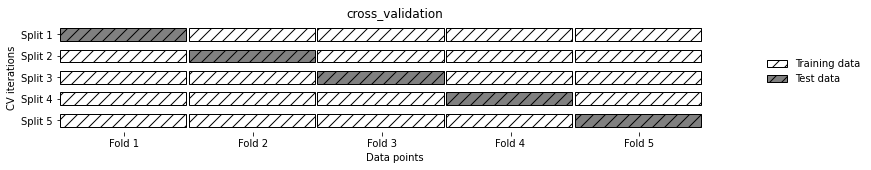

In [15]:
#cross_val_score(모델명, 훈련데이터, 타깃, cv) 
# cv는 폴드 수. 기본값은 3이다. 

import mglearn
mglearn.plots.plot_cross_validation()

In [16]:
# cross_val_score() 함수로 폴드가 3개인 k-겹 교차검증을 사용해 SGDClassifier 모델을 평가
# k-겹 교차 검증은 훈련 세트를 k개(여기서는 3개)의 폴드로 나누고, 각 폴드에 대해 예측을 만들고 평가하기 위해 나머지 폴드로 훈련시킨 모델을 사용. 

from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy") # 정확도

array([0.95035, 0.96035, 0.9604 ])

# 정확도(Accuracy) : 실제데이터와 예측데이터가 얼마나 같은지를 판단하는 지표

정확도 = 예측 데이터가 동일한 데이터 건수 / 전체 예측 데이터 건수

직관적으로 모델 예측 성능을 나타내는 평가 지표이지만 이진 분류의 경우 데이터의 구성에 따라 모델 성능을 왜곡할 수 있음

가령, 타이타닉 예제에서도 여성의 생존률이 높았기 때문에, 특별한 알고리즘 없이 여성을 생존, 남성을 사망으로 분류해도 정확도는 높을 수 있음 ( 단순히 하나의 조건만 가지고 결정하는 알고리즘도 높은 정확도를 나타내는 상황이 발생)

### stratified k-fold cross-validation (계층별 k-겹 교차검증)

StratifiedKFold함수는 매개변수로 n_splits, shuffle, random_state를 가진다.

n_splits은 몇 개로 분할할지를 정하는 매개변수이고, shuffle의 기본값 False 대신 True를 넣으면 Fold를 나누기 전에 무작위로 섞는다. 
그 후, cross_val_score함수의 cv 매개변수에 넣으면 된다.

데이터가 편향되어 있을 경우(몰려있을 경우) 단순 k-겹 교차검증을 사용하면 성능 평가가 잘되지 않을 수 있다. 
일반적으로 회귀에는 기본 k-겹 교차검증을 사용하고, 분류에는 StratifiedKFold를 사용한다. 

In [17]:
# model_selection의 clone은 데이터까지 복사하는 것이 아니라 model만 복사하는 함수이다. 

from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

# shuffle=False가 기본값이기 때문에 random_state를 삭제하던지 shuffle=True로 지정하라는 경고가 발생합니다.
# 0.24버전부터는 에러가 발생할 예정이므로 향후 버전을 위해 shuffle=True을 지정합니다.
skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


In [18]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None): # fit 메서드는 아무것도 학습하지 않음
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool) # predict 메서드는 '5아님' 클래스로 분류하는 더미 만들기

In [19]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

### 오차 행렬(Confusion Matrix)

: 클래스 A의 샘플이 클래스 B로 분류된 횟수 세기. 

- 실제 타깃과 비교할 수 있도록 먼저 예측값을 만들어야 한다. 

- cross_val_score처럼 cross_val_predict 함수는 k-겹 교차검증을 수행하지만 평가 점수를 반환하지 않고 각 테스트 폴드에서 얻은 예측을 반환한다.즉 훈련세트의 모든 샘플에 대해 깨끗한 예측을 얻게 된다. 모델이 훈련하는 동안 보지못했던 데이터에 대해 예측했다는 의미이다. 

- 오차행렬의 행은 실제 클래스를 나타내고, 열은 예측한 클래스를 나타낸다. 

In [20]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [21]:
# 첫번째 행은 5아닌 이미지(음성 클래스)이고, 두 번째 행은 5인 이미지(양성 클래스)이다. 

from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [22]:
# 완벽한 분류기라면 진짜 양성과 음성만 가지고 있을 것이므로 오차 항렬의 주대각선만 0이 아닌 값이 된다. 

y_train_perfect_predictions = y_train_5  # 완변한척 하자
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

In [23]:
# 정밀도와 재현을 포함하여 분류기의 지표를 계산하는 함수

from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [24]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [25]:
# f1점수
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

In [26]:
# SGDClassifier는 결정 함수(decision function)를 사용하여 각 샘플의 점수를 계산한다. 
# 이 점수가 임곗값보다 크면 샘플을 양성 클래스에 할당하고 그렇지 않으면 음성 클래스에 할당한다. 
# decision_function을 통해 예측에 사용할 점수 확인. 

y_scores = sgd_clf.decision_function([some_digit]) #각 샘플의 점수 확인하는 메서드.
y_scores

array([2164.22030239])

In [27]:
# 임곗값이 0이므로 위 코드는 predict() 메서드와 같은 결과(즉 True)를 반환한다. 
# threshold:임곗값

threshold = 0
y_some_digit_pred = (y_scores > threshold)

In [28]:
# 입곗값 높이면 재현율이 줄어든다. 
# 이미지가 실제로 숫자 5이고, 입계값이 0이면 분류기가 이를 감지하겠지만 임곗값을 8,000으로 높이면 이를 놓치게 된다. 

threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [29]:
# 훈련 세트에 있는 모든 샘플의 점수를 구해야 한다.
# 예측결과가 아니라 결정점수를 반환받도록 지정해야 한다.

y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

In [30]:
# 위의 점수로 precision_recall_curve() 함수를 사용하여 가능한 모든 임곗값에 대해 정밀도와 재현율을 계산할 수 있다. 
# precision_recall_curve 함수는 가능한 모든 임계값(결정 함수에 나타난 모든 값)에 대해 정밀도와 재현율의 값을 정렬된 리스트로 반환한다.

from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

<function matplotlib.pyplot.show(*args, **kw)>

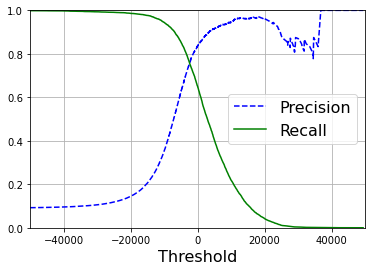

In [31]:
# 맷플롯립을 이용해 임곗값의 함수로 정밀도와 재현율을 그릴 수 있다. 


def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.legend(loc="center right", fontsize=16) 
    plt.xlabel("Threshold", fontsize=16)        
    plt.grid(True)                              
    plt.axis([-50000, 50000, 0, 1])             


plot_precision_recall_vs_threshold(precisions,recalls,thresholds)
plt.show

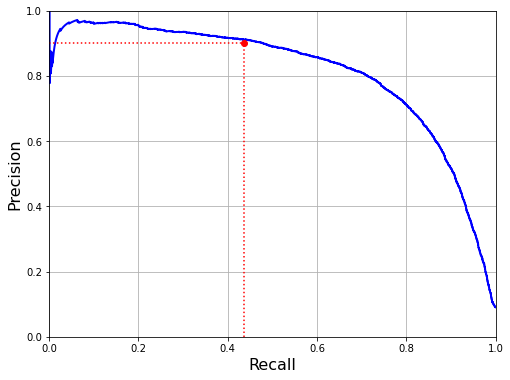

In [32]:
# 좋은 정밀도/ 제현율 트레이드 오프를 선택하는 다른 방법은 재현율에 대한 정밀도 곡선을 그리는 것이다. 
# 재현율 80% 근처에서 정밀도가 급격하게 줄어들기 시작한다.이 하강점 직전을 정밀도/재현율 트레이드오프로 선택하는 것이 좋다. 

def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([0.4368, 0.4368], [0., 0.9], "r:")
plt.plot([0.0, 0.4368], [0.9, 0.9], "r:")
plt.plot([0.4368], [0.9], "ro")
plt.show()

In [33]:
# 최소한 90% 정밀도가 되는 가장 낮은 임곗값 찾기. 
# np.argmax() 최댓값의 첫번째 인덱스 반환

threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

3370.0194991439557

In [35]:
# 훈련세트에 대한 예측을 만들려면 분류기의 predict() 메서드를 호출하는 대신 다음 코드 실행
# y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

y_train_pred_90 = (y_scores >= threshold_90_precision)

In [36]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [37]:
# 재현율이 너무 낮다면 높은 정밀도의 분류기는 전혀 유용하지 않다. 

recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

### ROC 곡선

거짓 양성 비율(FPR)에 대한 진짜 양성 비율(TPR:재현율의 다른 이름) 의 곡선이다. 

양성으로 잘못 분류된 음성 샘플의 비율이 FPR이다. 

이는 1에서 음성으롲 정확하게 분류한 음성 샘플의 비율인 진짜 음성 비율(TNR)을 뺀 값이다. TNR을 특이도라고 한다. 

그러므로 ROC 곡선은 민감도(재현율)에 대한 1-특이도 그래프이다. 


In [38]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

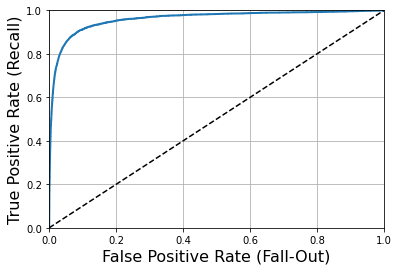

In [39]:
# 맷플롯립을 사용해 TPR에 대한FPR 곡선 나타내기.
# 모든 가능한 임곗값에서 진짜 양성 비율에 대한 거짓 양성 비율을 나타내는 곡선이다. 


def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1]) 
    plt.axis([0, 1, 0, 1])                                    
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) 
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    
    plt.grid(True)                                          


plot_roc_curve(fpr,tpr)
plt.show()

### 해석

재현율이 높을수록 분류기가 만드는 거짓 양성이 늘어난다. 점선은 완전한 랜덤 분류기의 ROC 곡선을 뜻한다. 

좋은 분류기는 이 점선에서 멀리 떨어져 있어야 한다.

곡선 아래의 면적(AUC)을 측정하면 분류기들을 비교할 수 있다.

완벽한 분류기는 ROC의 AUC가 1이고, 

완전한 랜덤 분류기(훈련 데이터의 클래스 비율에 따라 무작위로 예측하는 것. 실제 클래스가 비슷한 비율의 예측 클래스로 나뉘어 FPR과 TPR 값이 비슷해진다. 결국 ROC 곡선이 직선과 가깝게 되어 AUC 면적이 0.5가 된다) 는 0.5이다. 

In [40]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

### RandomForestClassifier을 훈련시켜 SGDClassifier의 ROC 곡선과 ROC AUC 점수를 비교

훈련 세트의 샘플에 대한 점수를 얻어야 한다. 그러나 작동 방식의 차이 떄문에 랜덤포레스트 분류기에는 결정함수 메서드가 없다.
대신 predict_proba를 가지고 있다. 

대부분의 분류기는 예측의 확신을 가늠하기 위한 decision_funcion이나 predict_proba 메서드를 제공한다. 예측을 만들어내는 것은 decision_function이나 predict_proba 출력의 임계값을 검증하는 것이다. 이진 탐색에서 decision_function은 0을, predict_proba는 0.5를 임계값으로 사용한다.

재현율보다 정밀도가 중요하거나 그 반대, 또는 데이터가 심하게 불균형일 때 결정 함수의 임계값을 바꾸면 더 나은 결과를 쉽게 얻을 수 있다. decision_function은 임의의 범위를 가지고 있으므로 임계점을 고르는 일반적인 방법을 제시하기는 어렵다.

predict_proba 메서드는 출력이 0에서 1 사이로 고정되니 임계값을 선택하기가 더 쉽다. 기본값인 0.5를 임계값으로 설정한 모델은 양성 클래스라는 확신이 50% 이상일 때 양성으로 분류한다. 임계값을 높이면 양성 클래스를 분류할 때 더 큰 확신이 필요하다. 반대로 음성 클래스는 확신이 덜 필요하다.




In [41]:
# precict_proba() 메서드는 샘플이 행, 클래스가 열이고 샘플이 주어진 클레스에 속할 확률을 담은 배열을 반환한다. 


from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

In [42]:
# roc_curve() 함수는 레이블과 점수가 필요하다. 하지만 점수 대신에 클래스 확률을 전달할 수 있다. 

y_scores_forest = y_probas_forest[:, 1] # 점수 = 양성 클래스의 확률
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

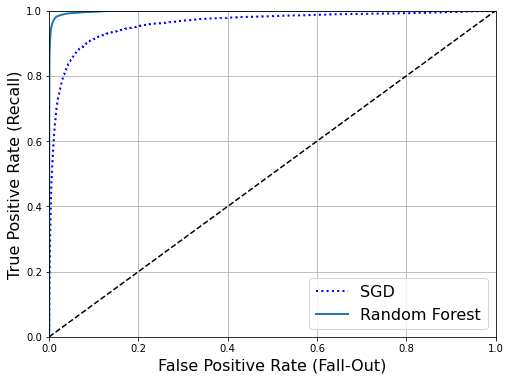

In [43]:
# roc 곡선 그리기
# 랜덤 포레스트 분류기가 SGD 분류기보다 훨씬 좋다. 
# 랜덤 포레스트의 ROC 곡선이 왼쪽 위 모서리에 더 가까워 AUC의 값이 크기 때문이다. 

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [44]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [45]:
# 정밀도와 재현율 계산

y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest)

0.9905083315756169

In [46]:
recall_score(y_train_5, y_train_pred_forest)

0.8662608374838591

# 3. 다중 분류

1) OvR 혹은 OvA: 특정 숫자 하나만 구분하는 숫자별 이진 분류기 10개를 훈련시켜 클래스가 10개인 숫자 이미지 분류 시스템을 만들 수 있다. 각 분류기의 결정 점수 중에서 가장 높은 것을 클래스로 선택하면 된다. 

=> 대부분의 이진 분류 알고리즘이 선호한다. 

2) OvO:각 숫자의 조합마다 이진 분류기를 훈련시킨다. 10개의 조합은 총 45개 분류기를 훈련시켜야 한다.

=> 훈련 세트의 크기에 민감한 서포트 벡터 머신 같은 일부 알고리즘은 작은 훈련 세트에서 많은 분류기를 훈련 시키는 쪽이 더 빠르다. 

In [47]:
# 서포트 벡터 머신 분류기->OvO 전략

from sklearn.svm import SVC

svm_clf = SVC(gamma="auto", random_state=42)
svm_clf.fit(X_train[:1000], y_train[:1000]) # y_train_5이 아니라 y_train입니다
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [48]:
# 샘플 당 10개의 점수를 반환한다. 클래스마다 하나씩이다. 
# 가장 높은 점수가 클래스 5에 해당하는 값이다. 

some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 2.81585438,  7.09167958,  3.82972099,  0.79365551,  5.8885703 ,
         9.29718395,  1.79862509,  8.10392157, -0.228207  ,  4.83753243]])

In [49]:
#최댓값의 첫 번째 인덱스를 반환

np.argmax(some_digit_scores)

5

In [50]:
#분류기가 훈련될 떄 classes_ 속성에 타깃 클래스의 리스트를 값으로 정렬하여 저장한다. 
# 각 클래스의 인덱스가 클래스 값 자체와 같은 드문 경우도 있다. 

svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [51]:
svm_clf.classes_[5]

5

In [52]:
#OvO나 OvR을 사용하도록 강제하려면 OneVsOneClassifier나 OneVsRestClassifier 사용한다. 

from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC(gamma="auto", random_state=42))
ovr_clf.fit(X_train[:1000], y_train[:1000])
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [53]:
len(ovr_clf.estimators_)

10

In [54]:
#SGD 분류기는 직접 샘플을 다중 클래스로 분류할 수 있기 때문에 별도로 사이킷런의 OvR이란 OvO를 적용할 필요가 없다. 

sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [55]:
# 클래스마다 부여한 점수 확인
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [56]:
# 분류기 평가를 위해 교차 검증 실행
# 모든 테스트 폴드(3개)에 84% 이상을 얻었다. 

cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [57]:
# 성능을 높이기 위해 표준화 진행

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

# 4.에러분석

In [58]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3) #예측 만들고
conf_mx = confusion_matrix(y_train, y_train_pred) #호출
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]],
      dtype=int64)

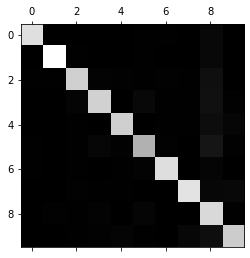

In [59]:
# 가장 큰 값은 흰색, 가장 작은 값은 검은색으로 정규화되어 그려진다. 
# 숫자5가 다른 숫자보다 더 어두워 보인다.
# 데이터셋에 숫자 5의 이미지가 적거나 분류기가 숫자5를 다른 숫자만큼 잘 분류하지 못한다는 것

plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [60]:
# 에러비율 비교하기(각 값을 대응되는 클래스의 이미지 개수로 나누기)
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

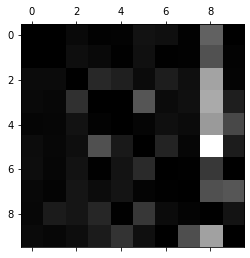

In [61]:
# 행은 실제 클래스, 열은 예측한 클래스를 나타낸다. 

np.fill_diagonal(norm_conf_mx, 0) # 주 대각선만 0으로 채우기
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

## 요악

클래스 8의 열이 상당히 밝으므로 많은 이미지가 8으로 잘못 분류되었음을 암시한다.

클래스 8의 행은 그리 나쁘지 않다. 이는 실제 8이 적절히 8로 분류되었음을 말한다.

=> 8로 잘못 분류되는 것을 줄이도록 개선할 필요가 있다. 

1) 8처럼 보이는, 하지만 실제 8은 아닌 숫자의 훈련 데이터를 더 많이 모아서 실제 8과 구분하도록 분류기를 학습시킬 수 있다. 

2) 분류기에 도움 될 만한 특성을 더 찾아볼 수 있다. 


In [69]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

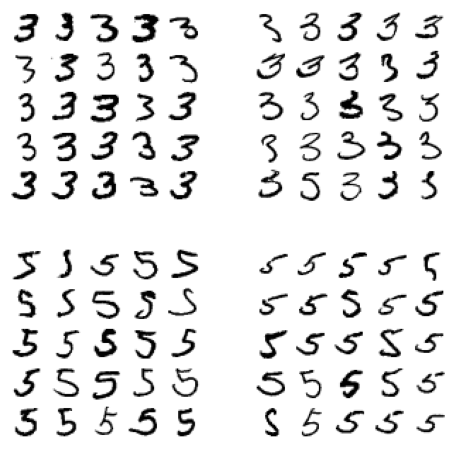

In [70]:
# 개개의 에러를 분석해보면 분류기가 무슨 일을 하고, 왜 잘못되었는지에 대한 통찰을 얻을 수 있다. 
# 선형 분류기는 클래스마다 픽셀에 가중치를 할당하고 새로운 이미지에 대해 단순히 픽셀 강도의 가중치 합을 클래스의 점수로 계산한다. 
# -> 분류기는 이미지의 위치나 회전 방향에 매우 민감하다. 따라서 오류를 줄이기 위해 이미지를 중앙에 위치하고, 회전되어 있지 않도록 전처리 한다. 

cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

# 5. 다중 레이블 분류

여러 개의 이진 꼬리표를 출력하는 분류 시스템을 다중 레이블 분류 시스템이라고 한다. 

In [65]:
from sklearn.neighbors import KNeighborsClassifier #KNeighborsClassifier은 다중 레이블 분류를 지원하지만 모든 분류기가 그런 것은 아니다. 
                                                    # 랜덤포레스트, 결정트리, OneVsRestClassifier에서도 다중 레이블 분류를 지원한다. 

y_train_large = (y_train >= 7) #숫자가 큰 값(7,8,9) 인지
y_train_odd = (y_train % 2 == 1) #홀수인지
y_multilabel = np.c_[y_train_large, y_train_odd] #각 숫자 이미지에 위의 두 개의 레이블에 담긴 배열 만들기. 

knn_clf = KNeighborsClassifier() #골격 만들기
knn_clf.fit(X_train, y_multilabel) # y_multilabel을 사용하여 훈련을 시킨다. 

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [66]:
#예측
# 숫자 5는 크지 않고, 홀수이다. 

knn_clf.predict([some_digit])

array([[False,  True]])

In [ ]:
# 다중 레이블 분류기를 평가하는 방법

y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

In [ ]:
# 타깃 레이블에 속한 샘풀수(지지도) 가중치 주기

y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="average")

# 6. 다중 충력 분류

다중 레이블 분류에서 한 레이블이 다중 클래스가 될 수 있도록 일반화한 것이다.

(즉 값을 2개 이상 가질 수 있다.)

In [67]:
noise = np.random.randint(0, 100, (len(X_train), 784)) #randint(): 픽셀 강도에 잡음을 추가
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train #타깃 이미지는 원본 이미지가 된다. 
y_test_mod = X_test

In [71]:

def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

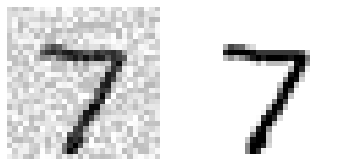

In [72]:
some_index = 0
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
plt.show()